# Yelp Data 

Import the python scientific suite

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import seaborn as sns
import scipy
import pylab

# This is importing a "future" python version 3 print function.
from __future__ import print_function
from __future__ import division
%matplotlib inline
sns.set()
sns.set_context('paper', font_scale = 1.5)
sns.set_style('ticks')

/Users/Franklin/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [3]:
def CountInstance(df, col_name):

    name, counts = np.unique(df[col_name], return_counts = True)
    counts_df = pd.DataFrame(data = {col_name: name, ('n_'+ col_name):counts})
    merged_df = pd.merge(df, counts_df, on = col_name, how = 'left')
    
    return(merged_df)

def TopChains(df, cutoff):
    #
    # Find the top chains
    # include a dataframe with column 'business_name'
    
    name, counts = np.unique(df['name'], return_counts = True)
    counts_df = pd.DataFrame(data = {'name': name, 'counts':counts})
    top_chains = counts_df.sort_values(by = 'counts', ascending = False)
    top_chains.index = range(len(top_chains)) #re-index
    
    return list(top_chains['name'][top_chains['counts'] > cutoff])

def OrderName(df, order_col, order_on):

    ordr = [] #median
    nme = [] #name

    for name in (np.unique(df[order_col])):
        nme.append(name)
        ordr.append(np.mean(df[df[order_col] == name][order_on].dropna()))

    order = list(pd.DataFrame([nme,ordr]).T.sort_values(by = 1)[0])
    
    return(order)

In [4]:
file_dir = '/Volumes/1TB_BAY/yelp_dataset_challenge_academic_dataset/'

r = pd.read_csv(file_dir + 'review_without_text_year.csv')
b = pd.read_csv('yelp_business_with_neighborhood.csv')
s = pd.read_csv('static_stats.csv')
u = pd.read_csv(file_dir + 'yelp_academic_dataset_user.csv')

/Users/Franklin/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,5,30,50,61,63,80,87,95) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
b = CountInstance(b, 'z_hood') #add number of resturants per neighborhood column
r = CountInstance(r, 'business_id') 

In [6]:
min_business_per_neighborhood = 2
min_reviews_per_business = 2
min_stores_per_chain = 50
min_reviews_per_user = 5

bf = b[(b['n_z_hood'] >= min_business_per_neighborhood)]
tc = TopChains(bf, min_stores_per_chain) #compute the top chains
bf = bf[bf['name'].isin(tc)] #filter to just the top chains
rf = pd.merge(r, bf, on = 'business_id', how = 'inner') #find just these reviews
rf = rf[(rf['n_business_id'] >= min_reviews_per_business)]

uf = u[(u['review_count'] >= min_reviews_per_user)]
rfu = pd.merge(rf, uf, on = 'user_id', how = 'inner')

rs = pd.merge(rfu, s, on = 'z_hood', how = 'inner')

bs = pd.merge(bf, s, on = 'z_hood', how = 'inner')

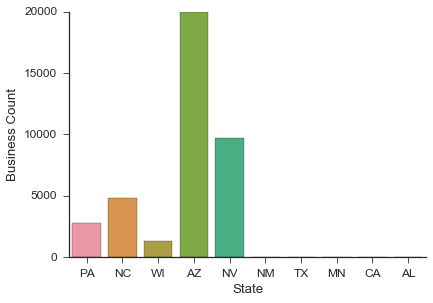

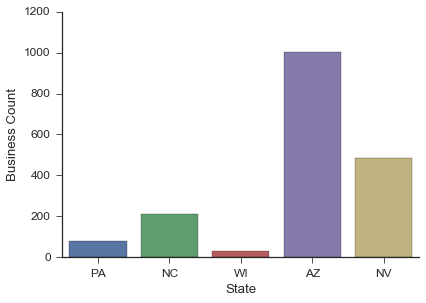

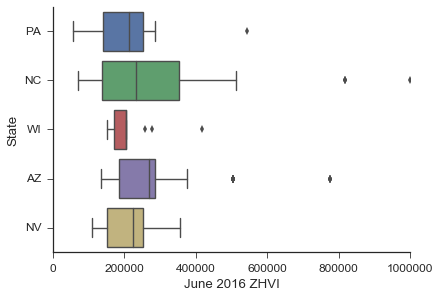

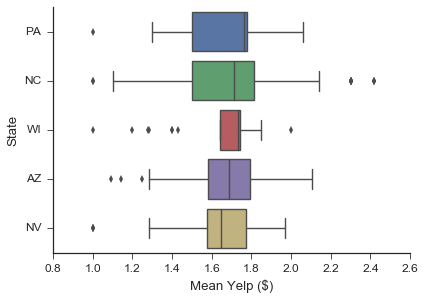

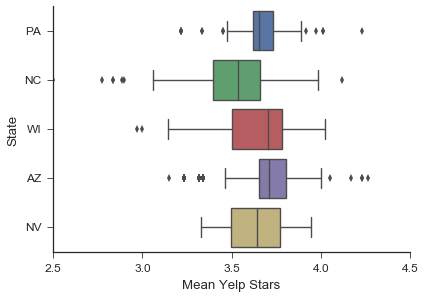

In [27]:
#total dataset
plt.figure()
sns.countplot(data = b, x = 'state')
plt.xlabel('State')
plt.ylabel('Business Count')
sns.despine()

#matched and filtered
plt.figure()
sns.countplot(data = bs, x = 'state_y')
plt.xlabel('State')
plt.ylabel('Business Count')
sns.despine()

#matched and filtered
plt.figure()
sns.boxplot(data = bs, x = 'latest_zhvi', y = 'state_y')
plt.ylabel('State')
plt.xlabel('June 2016 ZHVI')
sns.despine()

#matched and filtered
plt.figure()
sns.boxplot(data = bs, x = 'mean_price', y = 'state_y')
plt.ylabel('State')
plt.xlabel('Mean Yelp ($)')
sns.despine()

#matched and filtered
plt.figure()
sns.boxplot(data = bs, x = 'mean_stars', y = 'state_y')
plt.ylabel('State')
plt.xlabel('Mean Yelp Stars')
sns.despine()

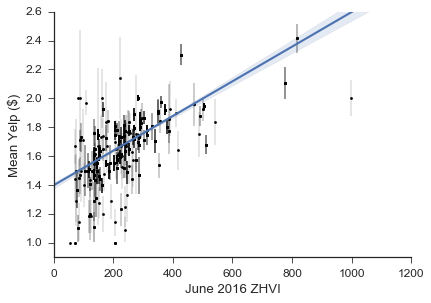

In [30]:
plt.figure()
plt.errorbar(bs['latest_zhvi']/1000.0, bs['mean_price'], bs['mean_price_err'], fmt = 'k.', lw = 0.2)
sns.regplot(bs['latest_zhvi']/1000.0, bs['mean_price'], bs['mean_price_err'], scatter_kws = {'s': 0})
plt.xlabel('June 2016 ZHVI')
plt.ylabel('Mean Yelp ($)')
plt.ylim(0.9,2.6)
#plt.colorbar(label = 'Number of Businesses in Neighborhood')
sns.despine()

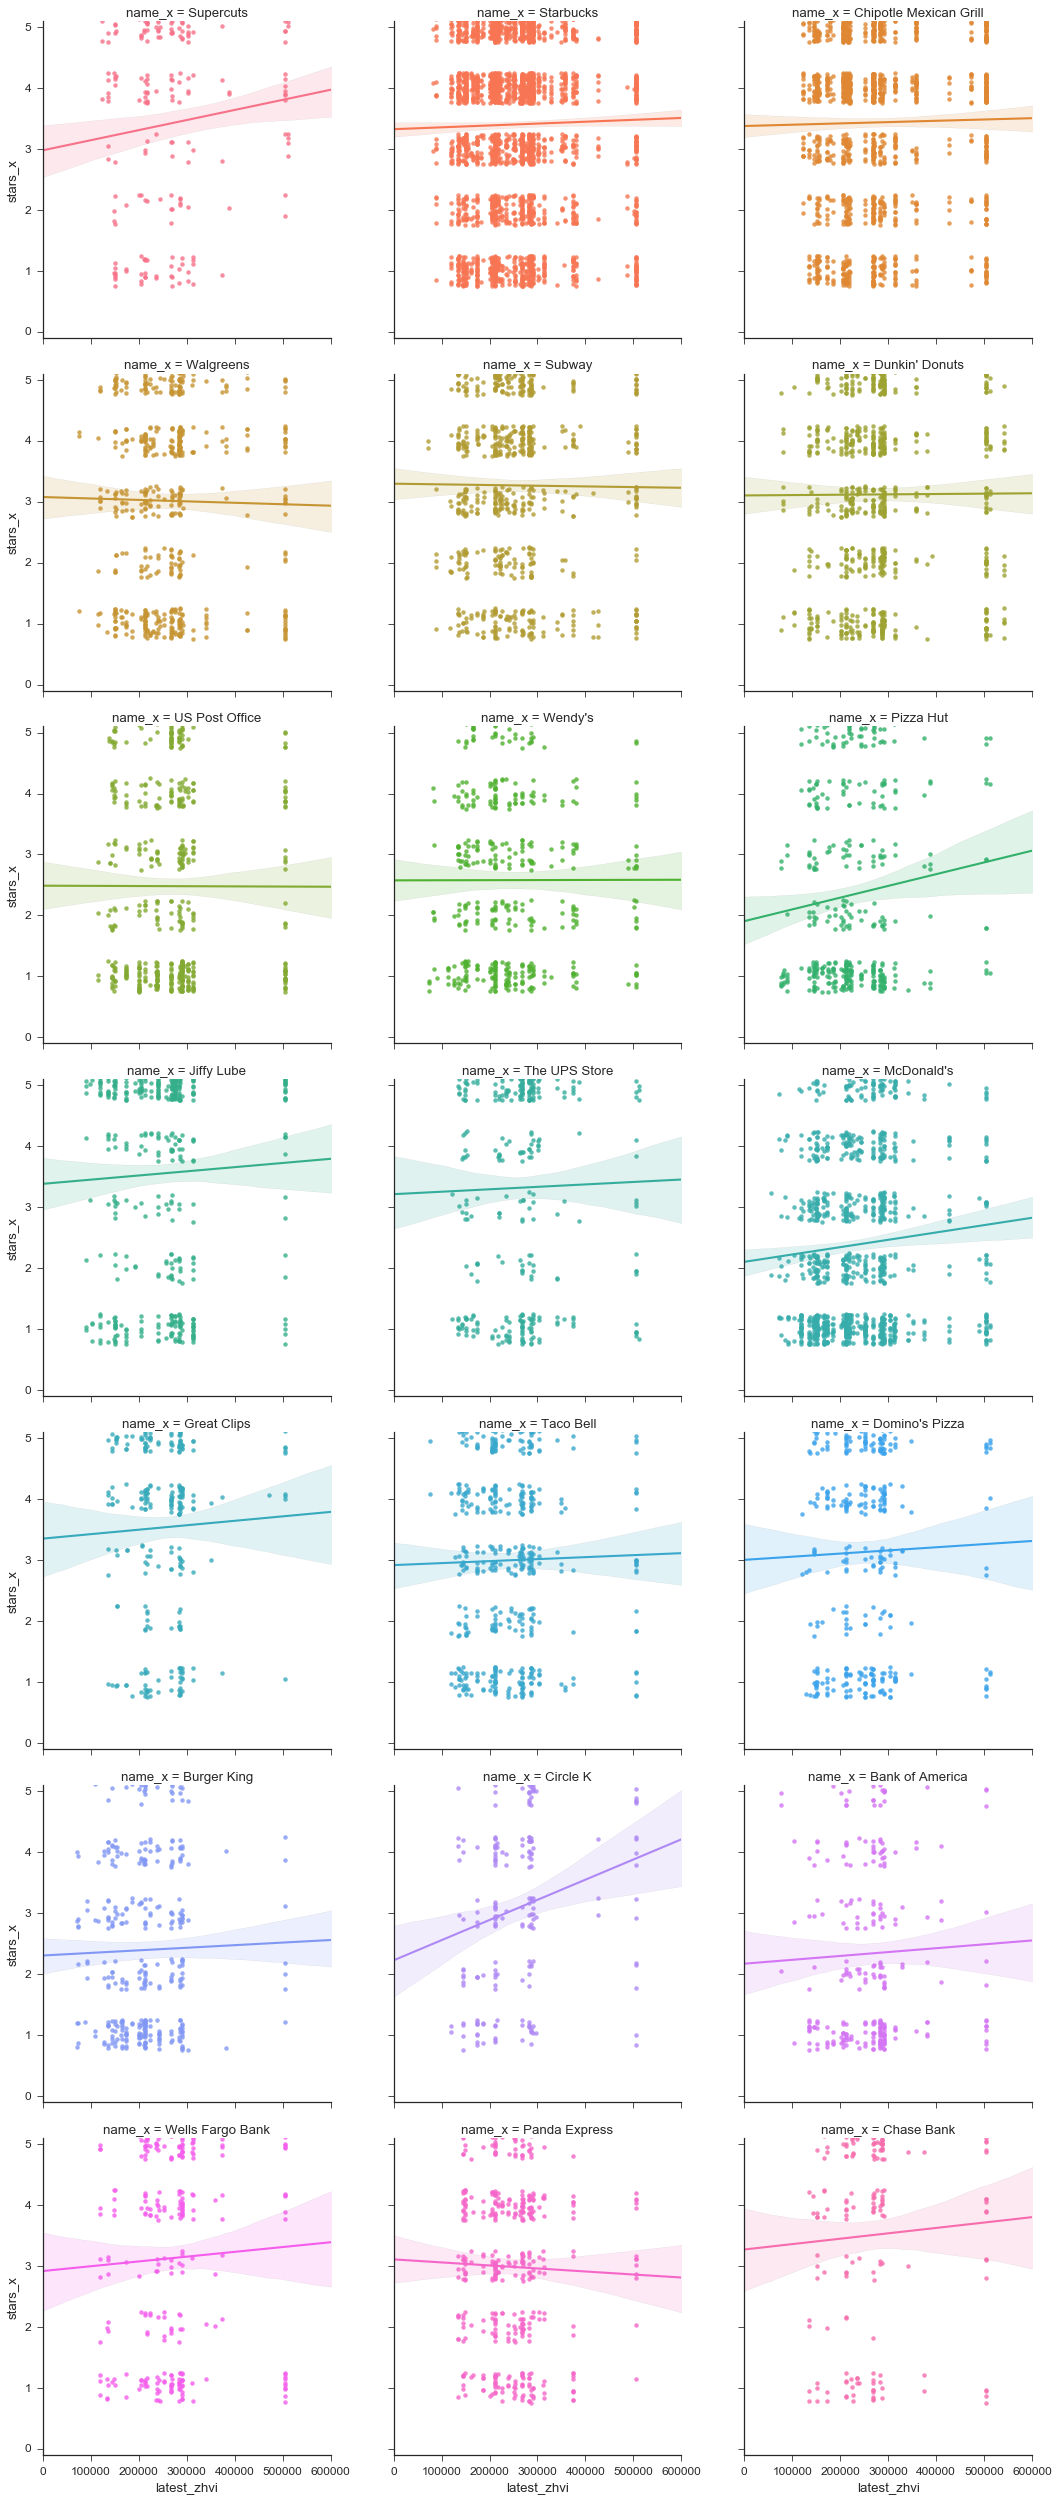

In [33]:
sns.lmplot(x = 'latest_zhvi', y = 'stars_x', col = 'name_x', hue = 'name_x', y_jitter = 0.25,  col_wrap = 3, data = rs)
plt.ylim(-0.1,5.1)
plt.xlim(0,600000)
sns.despine()
#plt.savefig('example_chain_regressions.png', dpi = 300, fmt = 'png')

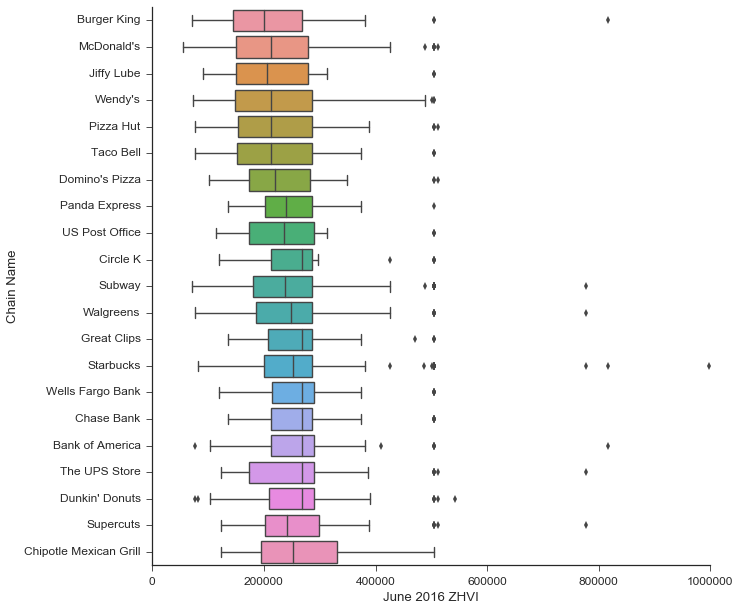

In [27]:
pylab.rcParams['figure.figsize'] = (10.0, 10.0) #set figure parameters
sns.boxplot(data = bs, x = 'latest_zhvi', y = 'name', order = OrderName(bs, 'name', 'latest_zhvi'))
plt.xlabel('June 2016 ZHVI')
plt.ylabel('Chain Name')
sns.despine()
#plt.savefig('rich_and_poor_chains.png', dpi = 300, fmt = 'png')

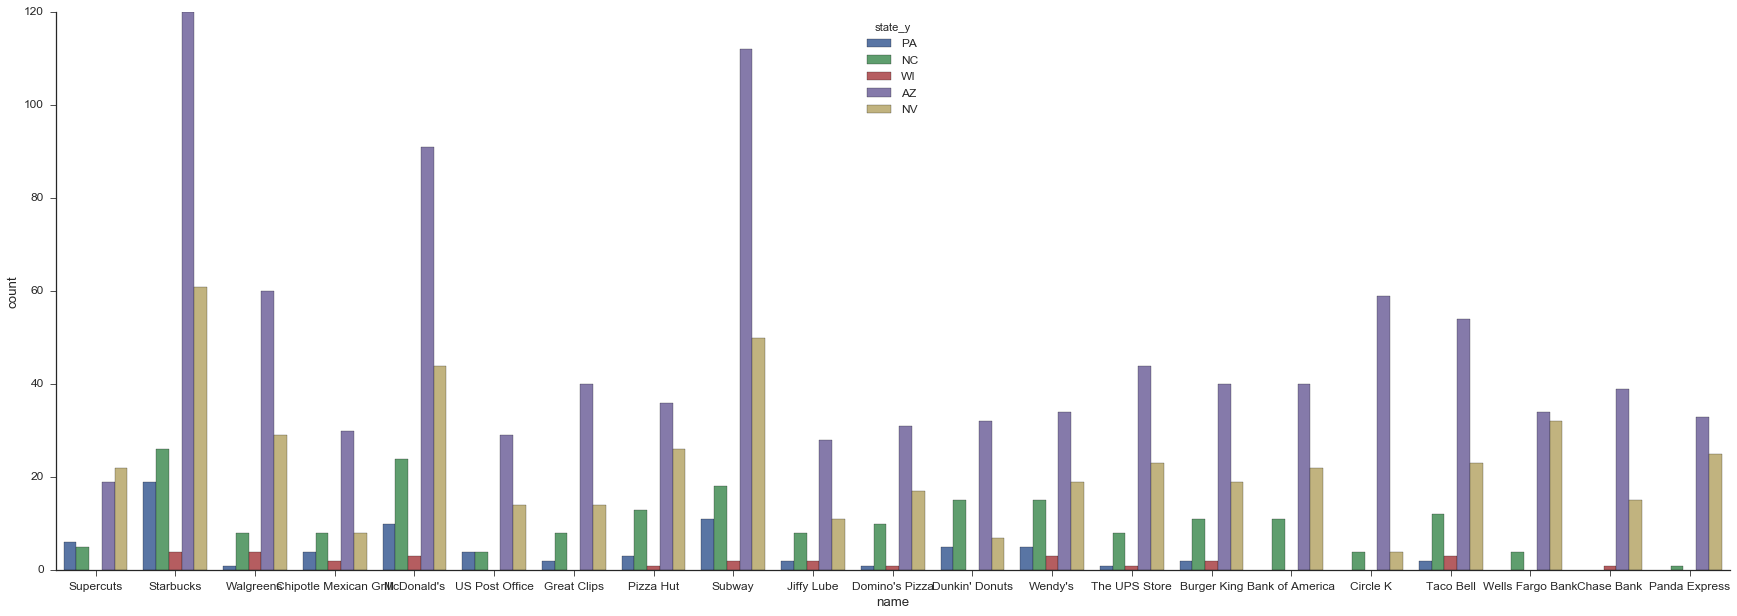

In [29]:
pylab.rcParams['figure.figsize'] = (30.0, 10.0) #set figure parameters
sns.countplot(data = bs, x = 'name', hue = 'state_y')
sns.despine()